In [11]:
import pandas as pd
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import os
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# =============================================================================
# 0. Hyperparameters & Setup
# =============================================================================
SEED = 42
# Data and Model Paths
RAW_PATH = 'real_data/df_raw_UDP_GOOGLE_HOME.csv'
MODELS_DIR = Path('models')
DATA_DIR = Path('synth_data')

# Create directories if they don't exist
MODELS_DIR.mkdir(parents=True, exist_ok=True)
DATA_DIR.mkdir(parents=True, exist_ok=True)

# Set random seeds for reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Model Hyperparameters
# Using values inspired by the paper where available
SEQUENCE_LENGTH = 42      # L, chosen based on the paper's 90th percentile analysis
LATENT_DIM = 16           # Dimension of the autoencoder's latent space
BATCH_SIZE = 128
AE_EPOCHS = 300           # The paper used 300, but 150 is often sufficient
WGAN_EPOCHS = 200         # Epochs for training the WGAN
AE_LR = 1e-3              # Autoencoder learning rate
WGAN_LR = 5e-5            # WGAN learning rate
N_CRITIC = 5              # Train critic 5 times per generator update
LAMBDA_GP = 10            # Gradient penalty lambda for WGAN-GP
TIME_DIFF_BINS = 100      # Number of bins for discretizing time_diff

# =============================================================================
# 1. Data Loading and Pre-processing
# =============================================================================
print('\u25ba Reading and pre-processing raw packets...')
df = pd.read_csv(
    RAW_PATH,
    usecols=['flow_id', 'payload_length', 'time_diff']
)

# Basic cleaning
_df_invalid = (~np.isfinite(df['payload_length'])) | (~np.isfinite(df['time_diff']))
if _df_invalid.any():
    print(f'  ! Dropping {_df_invalid.sum()} rows with non-finite values')
    df = df[~_df_invalid]

df['payload_length'] = df['payload_length'].clip(lower=0).fillna(0).astype(int)
df['time_diff'] = df['time_diff'].clip(lower=0).fillna(0)

# Get rid of rows that has time_diff > 25 miliseconds
df = df[df['time_diff'] < 25e-3] 

# Train/Test split by flow ID to ensure no data leakage
flow_ids = df['flow_id'].unique()
train_flows, test_flows = train_test_split(flow_ids, test_size=0.10, random_state=SEED)

train_df = df[df['flow_id'].isin(train_flows)]
test_df = df[df['flow_id'].isin(test_flows)]

# Get the lengths of test flows for final generation
test_flow_lengths = test_df.groupby('flow_id').size().tolist()

# =============================================================================
# 2. Model Definitions (Autoencoder & WGAN-GP)
# =============================================================================
# The architectures are based on Figures 3 & 4 in the paper

class Encoder(nn.Module):
    def __init__(self, vocab_size, sequence_length, latent_dim):
        super(Encoder, self).__init__()
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size

        self.td_dense1 = nn.Linear(vocab_size, 128)
        self.lstm1 = nn.LSTM(128, 128, batch_first=True)
        self.lstm2 = nn.LSTM(128, 64, batch_first=True)
        self.dense1 = nn.Linear(64 * sequence_length, latent_dim * 2) # Intermediate layer
        self.dense2 = nn.Linear(latent_dim * 2, latent_dim)
        self.tanh = nn.Tanh()

    def forward(self, x):
        # x shape: (batch, seq_len, vocab_size)
        x = self.tanh(self.td_dense1(x))
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = x.reshape(x.size(0), -1) # Flatten
        x = self.tanh(self.dense1(x))
        x = self.dense2(x) # No activation for latent vector
        return x

class Decoder(nn.Module):
    def __init__(self, vocab_size, sequence_length, latent_dim):
        super(Decoder, self).__init__()
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size

        self.dense1 = nn.Linear(latent_dim, 32)
        # RepeatVector equivalent is handled by unsqueeze and repeat
        self.lstm1 = nn.LSTM(32, 64, batch_first=True)
        self.lstm2 = nn.LSTM(64, 128, batch_first=True)
        self.td_dense1 = nn.Linear(128, vocab_size)
        self.tanh = nn.Tanh()

    def forward(self, x):
        # x shape: (batch, latent_dim)
        x = self.tanh(self.dense1(x))
        x = x.unsqueeze(1).repeat(1, self.sequence_length, 1) # RepeatVector
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = self.td_dense1(x) # Output logits for CrossEntropyLoss
        return x

class Autoencoder(nn.Module):
    def __init__(self, vocab_size, sequence_length, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(vocab_size, sequence_length, latent_dim)
        self.decoder = Decoder(vocab_size, sequence_length, latent_dim)

    def forward(self, x):
        latent = self.encoder(x)
        reconstruction = self.decoder(latent)
        return reconstruction

class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.Tanh(),
            nn.Linear(16, 16),
            nn.Tanh(),
            nn.Linear(16, 16),
            nn.Tanh(),
            nn.Linear(16, latent_dim) # Output layer with no activation
        )

    def forward(self, z):
        return self.net(z)

class Critic(nn.Module):
    def __init__(self, latent_dim):
        super(Critic, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(16, 16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(16, 16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.net(x)

# =============================================================================
# 3. Utility Functions
# =============================================================================

def build_sequences(data, sequence_length):
    """Groups data by flow_id and pads/truncates to sequence_length."""
    grouped = data.groupby('flow_id')
    sequences = []
    for _, group in grouped:
        seq = group['feature'].values.tolist()
        if len(seq) > sequence_length:
            seq = seq[:sequence_length] # Truncate
        else:
            seq.extend([0] * (sequence_length - len(seq))) # Pad with 0
        sequences.append(seq)
    return np.array(sequences, dtype=int)

def to_one_hot(sequences, vocab_size):
    """Converts integer sequences to one-hot encoded format."""
    one_hot = np.zeros((sequences.shape[0], sequences.shape[1], vocab_size), dtype=np.float32)
    for i, seq in enumerate(sequences):
        for j, val in enumerate(seq):
            if val < vocab_size:
                one_hot[i, j, val] = 1.0
    return one_hot

def compute_gradient_penalty(critic, real_samples, fake_samples):
    """Calculates the gradient penalty for WGAN-GP."""
    alpha = torch.randn(real_samples.size(0), 1, device=device)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = critic(interpolates)
    fake = torch.ones(real_samples.size(0), 1, device=device, requires_grad=False)
    
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

# =============================================================================
# 4. Main Training and Generation Function
# =============================================================================

def train_and_generate_feature(feature_name, train_data):
    """
    Main function to handle the full AE-WGAN pipeline for a single feature.
    """
    print(f"\n===== Processing feature: {feature_name} =====")
    
    # --- 4.1 Feature-specific Pre-processing ---
    print(f"\u25ba Building vocabulary and sequences for {feature_name}...")
    if feature_name == 'time_diff':
        # Bin continuous data to make it categorical
        train_data.loc[:, 'binned'] = pd.qcut(train_data[feature_name], q=TIME_DIFF_BINS, labels=False, duplicates='drop')
        feature_series = train_data['binned']
        # Create a mapping for binned values back to the original interval midpoints
        bin_edges = pd.qcut(train_data[feature_name], q=TIME_DIFF_BINS, duplicates='drop').unique()
        idx_to_val = {i: interval.mid for i, interval in enumerate(bin_edges)}
        idx_to_val[0] = 0 # Padding value
    else: # payload_length
        feature_series = train_data[feature_name]
        # Create mapping for payload values
        unique_vals = sorted(feature_series.unique())
        val_to_idx = {val: i+1 for i, val in enumerate(unique_vals)} # Reserve 0 for padding
        val_to_idx[0] = 0
        idx_to_val = {i: val for val, i in val_to_idx.items()}
        feature_series = feature_series.map(val_to_idx).fillna(0)

    vocab_size = len(idx_to_val)
    print(f"  Vocabulary size for {feature_name}: {vocab_size}")

    # Prepare sequences
    flow_sequences = build_sequences(
        pd.DataFrame({'flow_id': train_data['flow_id'], 'feature': feature_series}),
        SEQUENCE_LENGTH
    )
    one_hot_sequences = to_one_hot(flow_sequences, vocab_size)
    
    # PyTorch Dataset and DataLoader
    class SequenceDataset(Dataset):
        def __init__(self, data):
            self.data = torch.tensor(data, dtype=torch.float32)
        def __len__(self):
            return len(self.data)
        def __getitem__(self, idx):
            return self.data[idx]

    dataset = SequenceDataset(one_hot_sequences)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

    # --- 4.2 Step 1: Train Autoencoder ---
    print("\u25ba Training Autoencoder...")
    autoencoder = Autoencoder(vocab_size, SEQUENCE_LENGTH, LATENT_DIM).to(device)
    optimizer_ae = torch.optim.Adam(autoencoder.parameters(), lr=AE_LR)
    criterion_ae = nn.CrossEntropyLoss()

    for epoch in range(AE_EPOCHS):
        for data in dataloader:
            data = data.to(device)
            recon = autoencoder(data)
            # Reshape for CrossEntropyLoss: (N, C, d1, ...) -> (N*d1, C)
            loss = criterion_ae(recon.view(-1, vocab_size), data.view(-1, vocab_size))
            optimizer_ae.zero_grad()
            loss.backward()
            optimizer_ae.step()
        if (epoch + 1) % 25 == 0:
            print(f"  AE Epoch [{epoch+1}/{AE_EPOCHS}], Loss: {loss.item():.4f}")

    # --- 4.3 Step 2: Train WGAN-GP ---
    print("\u25ba Training WGAN-GP on latent space...")
    generator = Generator(LATENT_DIM).to(device)
    critic = Critic(LATENT_DIM).to(device)
    optimizer_g = torch.optim.Adam(generator.parameters(), lr=WGAN_LR, betas=(0.5, 0.9))
    optimizer_c = torch.optim.Adam(critic.parameters(), lr=WGAN_LR, betas=(0.5, 0.9))

    # Generate latent vectors from real data using the trained encoder
    autoencoder.eval()
    with torch.no_grad():
        real_latent_vectors = autoencoder.encoder(torch.tensor(one_hot_sequences).to(device))

    latent_dataset = torch.utils.data.TensorDataset(real_latent_vectors)
    latent_loader = DataLoader(latent_dataset, batch_size=BATCH_SIZE, shuffle=True)
    
    for epoch in range(WGAN_EPOCHS):
        for i, (real_latents,) in enumerate(latent_loader):
            # --- Train Critic ---
            for _ in range(N_CRITIC):
                optimizer_c.zero_grad()
                noise = torch.randn(real_latents.size(0), LATENT_DIM, device=device)
                fake_latents = generator(noise).detach()
                
                real_validity = critic(real_latents)
                fake_validity = critic(fake_latents)
                
                gradient_penalty = compute_gradient_penalty(critic, real_latents, fake_latents)
                c_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + LAMBDA_GP * gradient_penalty
                c_loss.backward()
                optimizer_c.step()

            # --- Train Generator ---
            optimizer_g.zero_grad()
            noise = torch.randn(real_latents.size(0), LATENT_DIM, device=device)
            gen_latents = generator(noise)
            g_loss = -torch.mean(critic(gen_latents))
            g_loss.backward()
            optimizer_g.step()

        if (epoch + 1) % 40 == 0:
            print(f"  WGAN Epoch [{epoch+1}/{WGAN_EPOCHS}], C Loss: {c_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

    # --- 4.4 Step 3: Generate Synthetic Sequences ---
    print(f"\u25ba Generating synthetic sequences for {feature_name}...")
    generator.eval()
    autoencoder.decoder.eval()
    
    generated_sequences = []
    num_to_generate = len(test_flow_lengths)
    
    with torch.no_grad():
        noise = torch.randn(num_to_generate, LATENT_DIM, device=device)
        synthetic_latents = generator(noise)
        synthetic_one_hot = autoencoder.decoder(synthetic_latents)
        
        # Convert one-hot back to integer indices
        synthetic_indices = torch.argmax(synthetic_one_hot, dim=2).cpu().numpy()

        for i, seq_indices in enumerate(synthetic_indices):
            # Map indices back to original values
            original_values = [idx_to_val.get(idx, 0) for idx in seq_indices]
            # Trim the sequence to the target length and remove padding
            true_length = test_flow_lengths[i]
            final_seq = original_values[:true_length]
            generated_sequences.append(final_seq)
            
    return generated_sequences

# =============================================================================
# 5. Execute Pipeline and Save Results
# =============================================================================

# Generate payload lengths
generated_payloads = train_and_generate_feature(
    'payload_length',
    train_df[['flow_id', 'payload_length']]
)

# Generate time diffs
generated_timediffs = train_and_generate_feature(
    'time_diff',
    train_df[['flow_id', 'time_diff']]
)

print("\n\u25ba Merging generated features into a final DataFrame...")

# Flatten the generated lists and create the DataFrame
records = []
flow_id_counter = 1
for i in range(len(test_flow_lengths)):
    payload_seq = generated_payloads[i]
    timediff_seq = generated_timediffs[i]
    
    # Ensure sequences have the same length (should match test_flow_lengths[i])
    num_packets = min(len(payload_seq), len(timediff_seq))
    
    for j in range(num_packets):
        records.append([
            flow_id_counter,
            int(round(payload_seq[j])), # Round to nearest integer payload
            max(0.0, timediff_seq[j])   # Ensure time_diff is non-negative
        ])
    if num_packets > 0:
        flow_id_counter += 1

synth_df = pd.DataFrame(records, columns=['flow_id', 'payload_length', 'time_diff'])
outfile = DATA_DIR / 'synthetic_packets_ae_wgan.csv'
synth_df.to_csv(outfile, index=False)

print(f"\n\u2714  Synthetic packets saved to {outfile}")
print(f"  Generated {synth_df.shape[0]} packets across {synth_df['flow_id'].nunique()} flows.")

Using device: cuda
► Reading and pre-processing raw packets...

===== Processing feature: payload_length =====
► Building vocabulary and sequences for payload_length...
  Vocabulary size for payload_length: 200
► Training Autoencoder...
  AE Epoch [25/300], Loss: 1.5990
  AE Epoch [50/300], Loss: 1.3212
  AE Epoch [75/300], Loss: 1.5276
  AE Epoch [100/300], Loss: 1.3369
  AE Epoch [125/300], Loss: 1.4707
  AE Epoch [150/300], Loss: 1.2640
  AE Epoch [175/300], Loss: 1.0662
  AE Epoch [200/300], Loss: 1.1087
  AE Epoch [225/300], Loss: 1.3555
  AE Epoch [250/300], Loss: 1.1507
  AE Epoch [275/300], Loss: 1.2456
  AE Epoch [300/300], Loss: 1.3052
► Training WGAN-GP on latent space...
  WGAN Epoch [40/200], C Loss: 7.1081, G Loss: 0.1215
  WGAN Epoch [80/200], C Loss: 1.7300, G Loss: 0.0921
  WGAN Epoch [120/200], C Loss: -4.0132, G Loss: 0.0838
  WGAN Epoch [160/200], C Loss: -7.8666, G Loss: 0.2127
  WGAN Epoch [200/200], C Loss: -9.4186, G Loss: 0.3440
► Generating synthetic sequences

In [12]:
# calculate KS stat between synth_df and test_df
from scipy.stats import ks_2samp
def calculate_ks_stat(synth_df, test_df, feature):
    synth_values = synth_df[feature].values
    test_values = test_df[feature].values
    ks_stat, p_value = ks_2samp(synth_values, test_values)
    return ks_stat, p_value
ks_payload = calculate_ks_stat(synth_df, test_df, 'payload_length')
ks_timediff = calculate_ks_stat(synth_df, test_df, 'time_diff')
print(f"\n\u25ba KS Statistic for payload_length: {ks_payload[0]:.4f}, p-value: {ks_payload[1]:.4f}")
print(f"\u25ba KS Statistic for time_diff: {ks_timediff[0]:.4f}, p-value: {ks_timediff[1]:.4f}")


► KS Statistic for payload_length: 0.8553, p-value: 0.0000
► KS Statistic for time_diff: 0.9111, p-value: 0.0000


KS  payload_length: D=0.8553  p=1.7739e-253
KS  time_diff     : D=0.9111  p=6.3850e-299


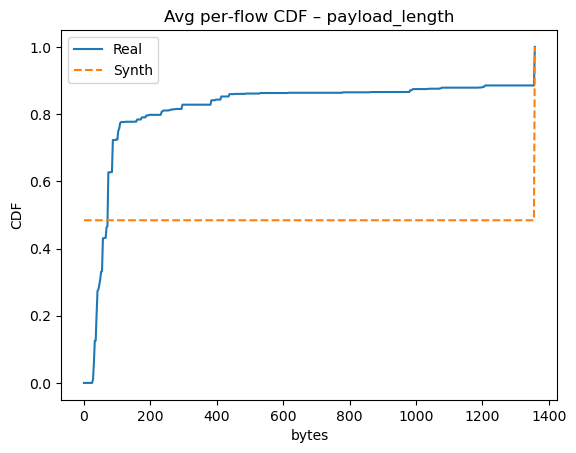

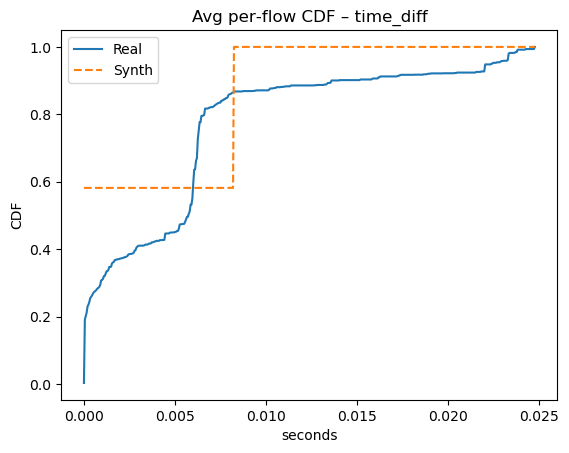

In [13]:
# ------------------------------------------------------------------ #
# 9  Sanity checks & CDF plots
# ------------------------------------------------------------------ #
import matplotlib.pyplot as plt

stat_p, p_p = ks_2samp(test_df.payload_length, synth_df.payload_length)
stat_t, p_t = ks_2samp(test_df.time_diff,      synth_df.time_diff)
print(f"KS  payload_length: D={stat_p:.4f}  p={p_p:.4e}")
print(f"KS  time_diff     : D={stat_t:.4f}  p={p_t:.4e}")

def avg_flow_cdf(rdf, sdf, feat, grid=500):
    lo, hi = min(rdf[feat].min(), sdf[feat].min()), \
             max(rdf[feat].max(), sdf[feat].max())
    xs = np.linspace(lo, hi, grid)
    def cdfs(df):
        out = []
        for _, g in df.groupby("flow_id"):
            v = np.sort(g[feat].values)
            out.append(np.searchsorted(v, xs, 'right')/len(v))
        return np.stack(out)
    return xs, cdfs(rdf).mean(0), cdfs(sdf).mean(0)

x1, r1, s1 = avg_flow_cdf(test_df, synth_df, "payload_length")
x2, r2, s2 = avg_flow_cdf(test_df, synth_df, "time_diff")

plt.figure(); plt.plot(x1, r1, label="Real"); plt.plot(x1, s1, "--", label="Synth")
plt.title("Avg per‑flow CDF – payload_length"); plt.xlabel("bytes"); plt.ylabel("CDF")
plt.legend(); plt.show()

plt.figure(); plt.plot(x2, r2, label="Real"); plt.plot(x2, s2, "--", label="Synth")
plt.title("Avg per‑flow CDF – time_diff"); plt.xlabel("seconds"); plt.ylabel("CDF")
plt.legend(); plt.show()

In [14]:
from statsmodels.tsa.stattools import acf
from scipy.stats import entropy
import scipy.signal as sg

def seqs_by_flow(df: pd.DataFrame, col: str):
    return [g.sort_index()[col].astype(float).values
            for _, g in df.groupby("flow_id") if len(g) > 1]

def average_psd(seqs, fs: float = 1.0, nfft: int = 256):
    psds = []
    freqs = None
    for x in seqs:
        f, p = sg.welch(x, fs=fs, nperseg=min(nfft, len(x)), nfft=nfft,
                         scaling="density", detrend=False)
        psds.append(p + 1e-12)  # avoid zeros
        if freqs is None:
            freqs = f
    return freqs, np.mean(psds, axis=0)

def kl_div(p, q):
    p, q = p / p.sum(), q / q.sum()
    return 0.5 * (entropy(p, q) + entropy(q, p))

# --- average CDF per flow ----------------------------------------------------
def avg_flow_cdf(rdf, sdf, feat, grid=500):
    lo, hi = min(rdf[feat].min(), sdf[feat].min()), \
             max(rdf[feat].max(), sdf[feat].max())
    xs = np.linspace(lo, hi, grid)

    def _flow_cdfs(df):
        mats = []
        for _, g in df.groupby('flow_id'):
            v = np.sort(g[feat].values)
            mats.append(np.searchsorted(v, xs, 'right') / len(v))
        return np.stack(mats)                 # (n_flows, grid)

    return xs, _flow_cdfs(rdf).mean(0), _flow_cdfs(sdf).mean(0)

# KL between the two *mean* CDFs (convert CDF→PDF via finite diff)
def kl_avg_flow_cdf(rdf, sdf, feat, grid=500):
    _, cdf_r, cdf_s = avg_flow_cdf(rdf, sdf, feat, grid)
    pdf_r = np.diff(cdf_r, prepend=0) + 1e-12   # avoid zeros
    pdf_s = np.diff(cdf_s, prepend=0) + 1e-12
    return kl_div(pdf_r, pdf_s)

def spectral_entropy_list(seqs, nfft: int = 256):
    ent = []
    for x in seqs:
        _, Pxx = sg.welch(x, nperseg=min(nfft, len(x)), nfft=nfft,
                          scaling="density")
        Pxx /= Pxx.sum()
        ent.append(entropy(Pxx, base=2))
    return np.asarray(ent)

def spectral_entropy_coverage(real, synth):
    def _e(v):
        _, P = sg.welch(v, nperseg=min(256, len(v)), nfft=256, scaling="density")
        P /= P.sum()
        return entropy(P, base=2)
    H_r = np.array([_e(x) for x in real])
    H_s = np.array([_e(x) for x in synth])
    cov = max(0, H_s.min() - H_r.min()) + max(0, H_r.max() - H_s.max())
    return cov / (H_r.max() - H_r.min() + 1e-12)

def mean_acf(seqs, nlags=20, fft=True):
    """
    Element-wise mean ACF over a list of 1-D sequences.

    • If a sequence is shorter than `nlags+1`, we let acf() return the
      maximum it can (len(x) lags).
    • After collecting all ACFs, we truncate every vector to the *shortest*
      length found, so we have a neat (n_flows, L) matrix.
    """
    acfs = []
    for x in seqs:
        if len(x) < 2:
            continue                      # needs at least 2 points
        L = min(nlags, len(x) - 1)
        acfs.append(acf(x, nlags=L, fft=fft))

    if not acfs:
        raise ValueError("No sequences long enough to compute ACF")

    # truncate to common length
    Lmin = min(a.size for a in acfs)
    acfs = np.stack([a[:Lmin] for a in acfs])
    return acfs.mean(axis=0)


metrics = {}
metrics["ks_payload"] = ks_2samp(test_df.payload_length, synth_df.payload_length).statistic
metrics["ks_time"]    = ks_2samp(test_df.time_diff,      synth_df.time_diff).statistic

rp, psd_r = average_psd(seqs_by_flow(test_df, "payload_length"))
_,  psd_s = average_psd(seqs_by_flow(synth_df, "payload_length"))
metrics["kl_psd_payload"] = kl_div(psd_r, psd_s)

rt, tpd_r = average_psd(seqs_by_flow(test_df, "time_diff"))
_,  tpd_s = average_psd(seqs_by_flow(synth_df, "time_diff"))
metrics["kl_psd_time"] = kl_div(tpd_r, tpd_s)

metrics['kl_cdf_payload'] = kl_avg_flow_cdf(test_df,   synth_df, 'payload_length')
metrics['kl_cdf_time']    = kl_avg_flow_cdf(test_df,   synth_df, 'time_diff')

metrics["diversity_payload"] = spectral_entropy_coverage(
    seqs_by_flow(test_df, "payload_length"), seqs_by_flow(synth_df, "payload_length"))
metrics["diversity_time"] = spectral_entropy_coverage(
    seqs_by_flow(test_df, "time_diff"), seqs_by_flow(synth_df, "time_diff"))

ent_real_pl = spectral_entropy_list(seqs_by_flow(test_df, "payload_length"))
ent_synt_pl = spectral_entropy_list(seqs_by_flow(synth_df, "payload_length"))
metrics["delta_mean_payload"] = float(abs(ent_synt_pl.mean() - ent_real_pl.mean()))

ent_real_td = spectral_entropy_list(seqs_by_flow(test_df, "time_diff"))
ent_synt_td = spectral_entropy_list(seqs_by_flow(synth_df, "time_diff"))
metrics["delta_mean_time"] = float(abs(ent_synt_td.mean() - ent_real_td.mean()))

acf_r_payload = mean_acf(seqs_by_flow(test_df,  "payload_length"))
acf_s_payload = mean_acf(seqs_by_flow(synth_df, "payload_length"))
L = min(len(acf_r_payload), len(acf_s_payload))    
metrics['acf_rmse_payload'] = np.sqrt(
    ((acf_r_payload[:L] - acf_s_payload[:L]) ** 2).mean())

acf_r_time = mean_acf(seqs_by_flow(test_df,  "time_diff"))
acf_s_time = mean_acf(seqs_by_flow(synth_df, "time_diff"))
L = min(len(acf_r_time), len(acf_s_time))
metrics['acf_rmse_time'] = np.sqrt(
    ((acf_r_time[:L] - acf_s_time[:L]) ** 2).mean())

# --- print metrics -----------------------------------------------------------
print("\n=== Metrics - HTTP ===")
for k, v in metrics.items():
    print(f"{k:<25} : {v:.4g}")


=== Metrics - HTTP ===
ks_payload                : 0.8553
ks_time                   : 0.9111
kl_psd_payload            : 0.7344
kl_psd_time               : 0.1423
kl_cdf_payload            : 17.7
kl_cdf_time               : 14.3
diversity_payload         : 0
diversity_time            : 0
delta_mean_payload        : nan
delta_mean_time           : 1.65
acf_rmse_payload          : nan
acf_rmse_time             : 0.06395
